# MLB Drag analysis 

## Data Preprocessing

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from scipy import stats


### Extract

In [57]:
# Load the dataset
data = pd.read_csv('data/data_sample.csv')


### Transform

In [58]:
# Convert categorical variables to category type
categorical_cols = ['pitcher_throws', 'bat_side', 'pitch_type', 'event_result']
for col in categorical_cols:
    data[col] = data[col].astype('category')

# Convert numeric columns to appropriate types
numeric_cols = ['release_speed', 'plate_speed', 'hit_exit_speed', 'hit_spinrate',
                'hit_vertical_angle', 'hit_bearing', 'hit_distance']
for col in numeric_cols:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Handle missing values
data['hit_spinrate'].fillna(data['hit_spinrate'].median(), inplace=True)

# Remove rows with missing critical data
data.dropna(subset=['hit_exit_speed', 'hit_distance'], inplace=True)

# Create derived features
data['speed_loss'] = data['release_speed'] - data['plate_speed']
cleaned_data = data

/var/folders/h0/0dm3gkqs0mggsr5136nxc6j40000gn/T/ipykernel_39809/3422535559.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['hit_spinrate'].fillna(data['hit_spinrate'].median(), inplace=True)


### Load

In [59]:
# Define the output folder and ensure it exists
output_folder = 'output'
os.makedirs(output_folder, exist_ok=True)
output_file = os.path.join(output_folder, 'cleaned_data.csv')
data.to_csv(output_file, index=False)

print(f"Processed data saved to {output_file}")

Processed data saved to output/cleaned_data.csv


## Exploratory Data Analysis

In [60]:
# Basic data exploration
print(cleaned_data.info())
print(cleaned_data.describe())

# Check for any remaining missing values
print(cleaned_data.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
Index: 4522 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   year                4522 non-null   int64   
 1   month               4522 non-null   int64   
 2   pitcher_throws      4522 non-null   category
 3   bat_side            4522 non-null   category
 4   pitch_type          4522 non-null   category
 5   release_speed       4522 non-null   float64 
 6   plate_speed         4522 non-null   float64 
 7   hit_exit_speed      4522 non-null   float64 
 8   hit_spinrate        4522 non-null   float64 
 9   hit_vertical_angle  4522 non-null   float64 
 10  hit_bearing         4522 non-null   float64 
 11  hit_distance        4522 non-null   float64 
 12  event_result        4522 non-null   category
 13  speed_loss          4522 non-null   float64 
dtypes: category(4), float64(8), int64(2)
memory usage: 407.4 KB
None
              year        mo

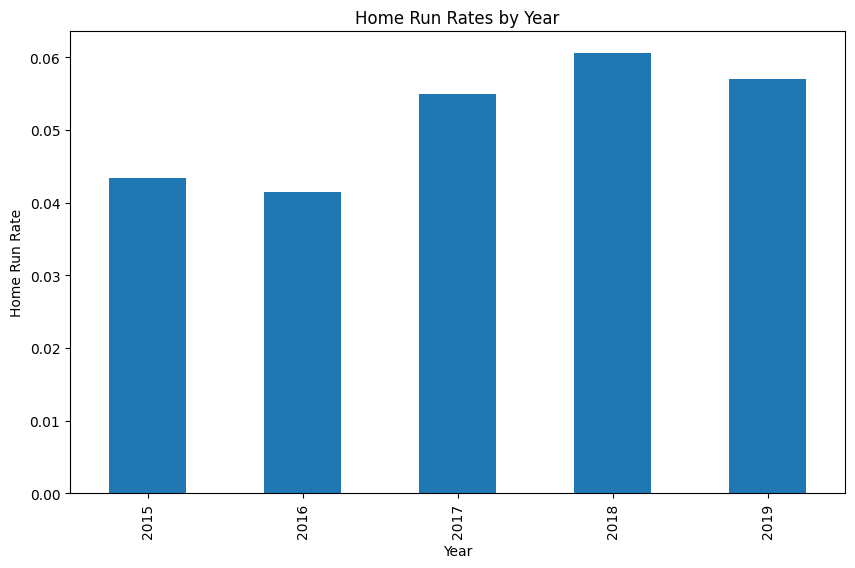

In [61]:
# Analyze homerun rates over time
hr_rates = cleaned_data.groupby('year')['event_result'].apply(lambda x: (x == 'home_run').mean())

plt.figure(figsize=(10, 6))
hr_rates.plot(kind='bar')
plt.title('Home Run Rates by Year')
plt.ylabel('Home Run Rate')
plt.xlabel('Year')
plt.show()

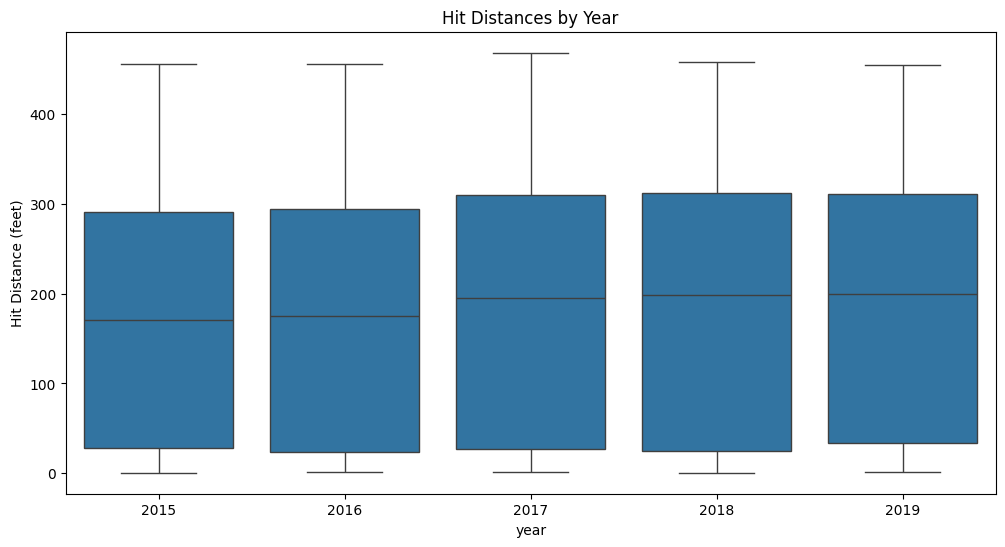

In [62]:
# Analyze hit distances over time
plt.figure(figsize=(12, 6))
sns.boxplot(x='year', y='hit_distance', data=cleaned_data)
plt.title('Hit Distances by Year')
plt.ylabel('Hit Distance (feet)')
plt.show()

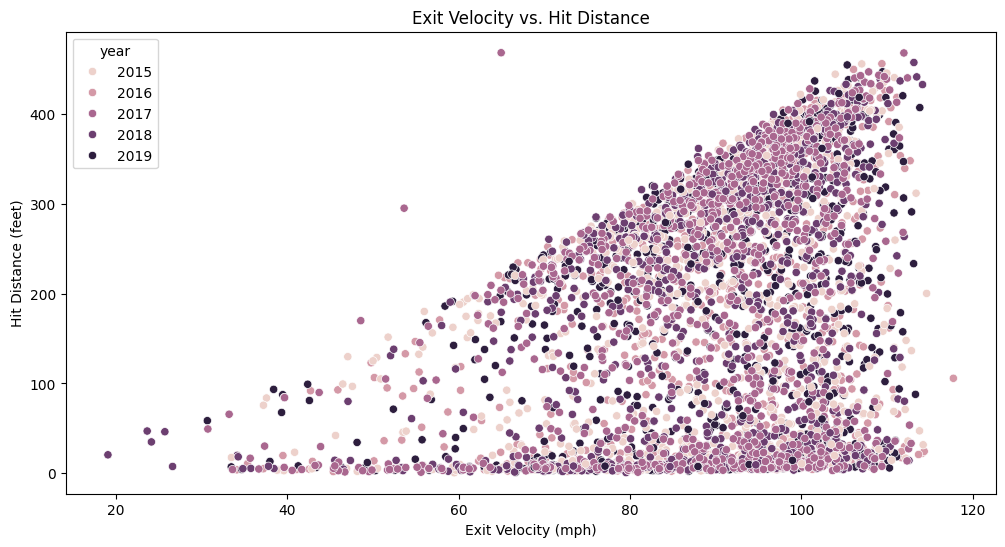

In [63]:
# Examine relationship between exit velocity and distance
plt.figure(figsize=(12, 6))
sns.scatterplot(x='hit_exit_speed', y='hit_distance', hue='year', data=cleaned_data)
plt.title('Exit Velocity vs. Hit Distance')
plt.xlabel('Exit Velocity (mph)')
plt.ylabel('Hit Distance (feet)')
plt.show()

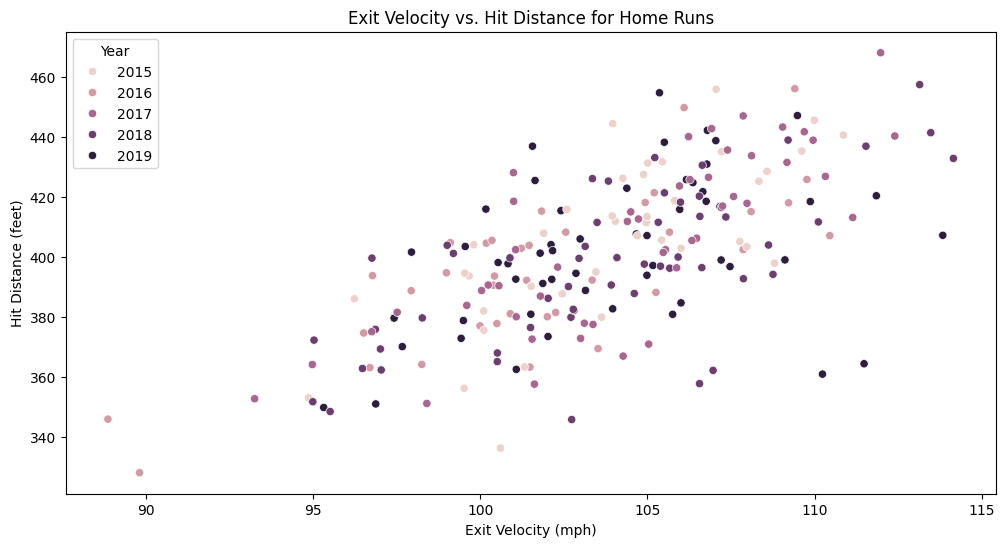

In [70]:
# Filter the data to include only home runs
hr_data = cleaned_data[cleaned_data['event_result'] == 'home_run']

# Create the scatter plot
plt.figure(figsize=(12, 6))
sns.scatterplot(x='hit_exit_speed', y='hit_distance', hue='year', data=hr_data)
plt.title('Exit Velocity vs. Hit Distance for Home Runs')
plt.xlabel('Exit Velocity (mph)')
plt.ylabel('Hit Distance (feet)')
plt.legend(title='Year')
plt.show()

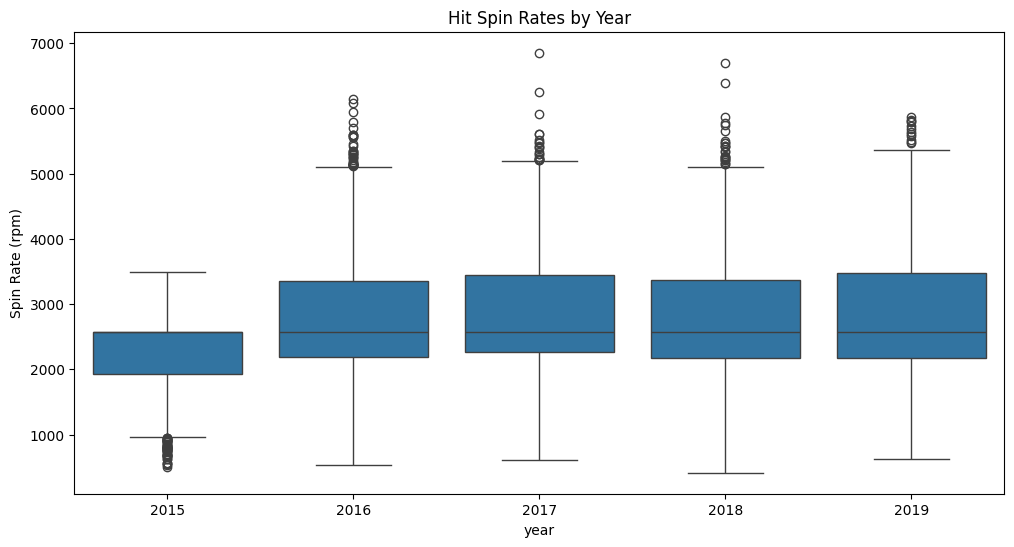

In [64]:
# Analyze spin rates over time
plt.figure(figsize=(12, 6))
sns.boxplot(x='year', y='hit_spinrate', data=cleaned_data)
plt.title('Hit Spin Rates by Year')
plt.ylabel('Spin Rate (rpm)')
plt.show()

In [65]:
# Compare hit distances between first and last year
first_year = cleaned_data['year'].min()
last_year = cleaned_data['year'].max()

first_year_distances = cleaned_data[cleaned_data['year'] == first_year]['hit_distance']
last_year_distances = cleaned_data[cleaned_data['year'] == last_year]['hit_distance']

t_stat, p_value = stats.ttest_ind(first_year_distances, last_year_distances)
print(f"T-statistic: {t_stat}, p-value: {p_value}")

T-statistic: -2.1109304421763544, p-value: 0.03491382907470867


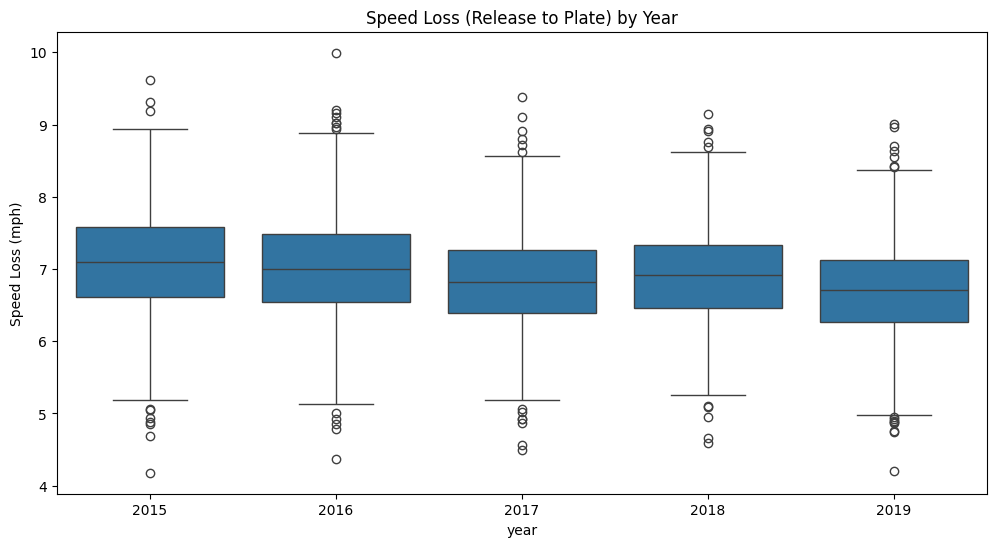

In [66]:
# Speed loss from release to plate
plt.figure(figsize=(12, 6))
sns.boxplot(x='year', y='speed_loss', data=cleaned_data)
plt.title('Speed Loss (Release to Plate) by Year')
plt.ylabel('Speed Loss (mph)')
plt.show()

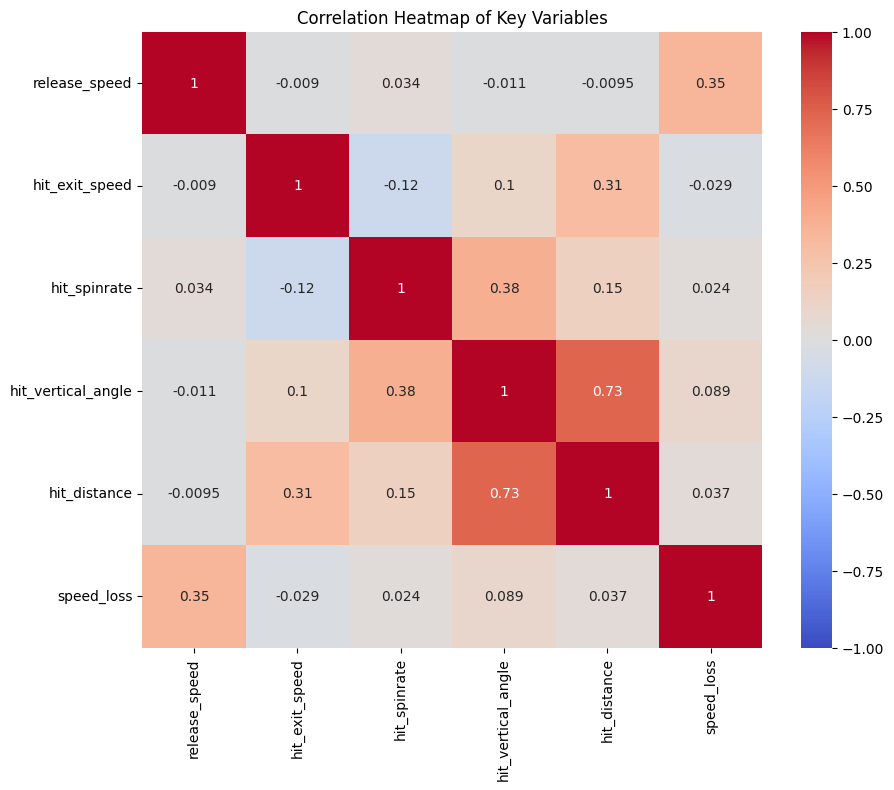

In [67]:
# Correlation heatmap
correlation_matrix = cleaned_data[['release_speed', 'hit_exit_speed', 'hit_spinrate',
                                   'hit_vertical_angle', 'hit_distance', 'speed_loss']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Heatmap of Key Variables')
plt.show()

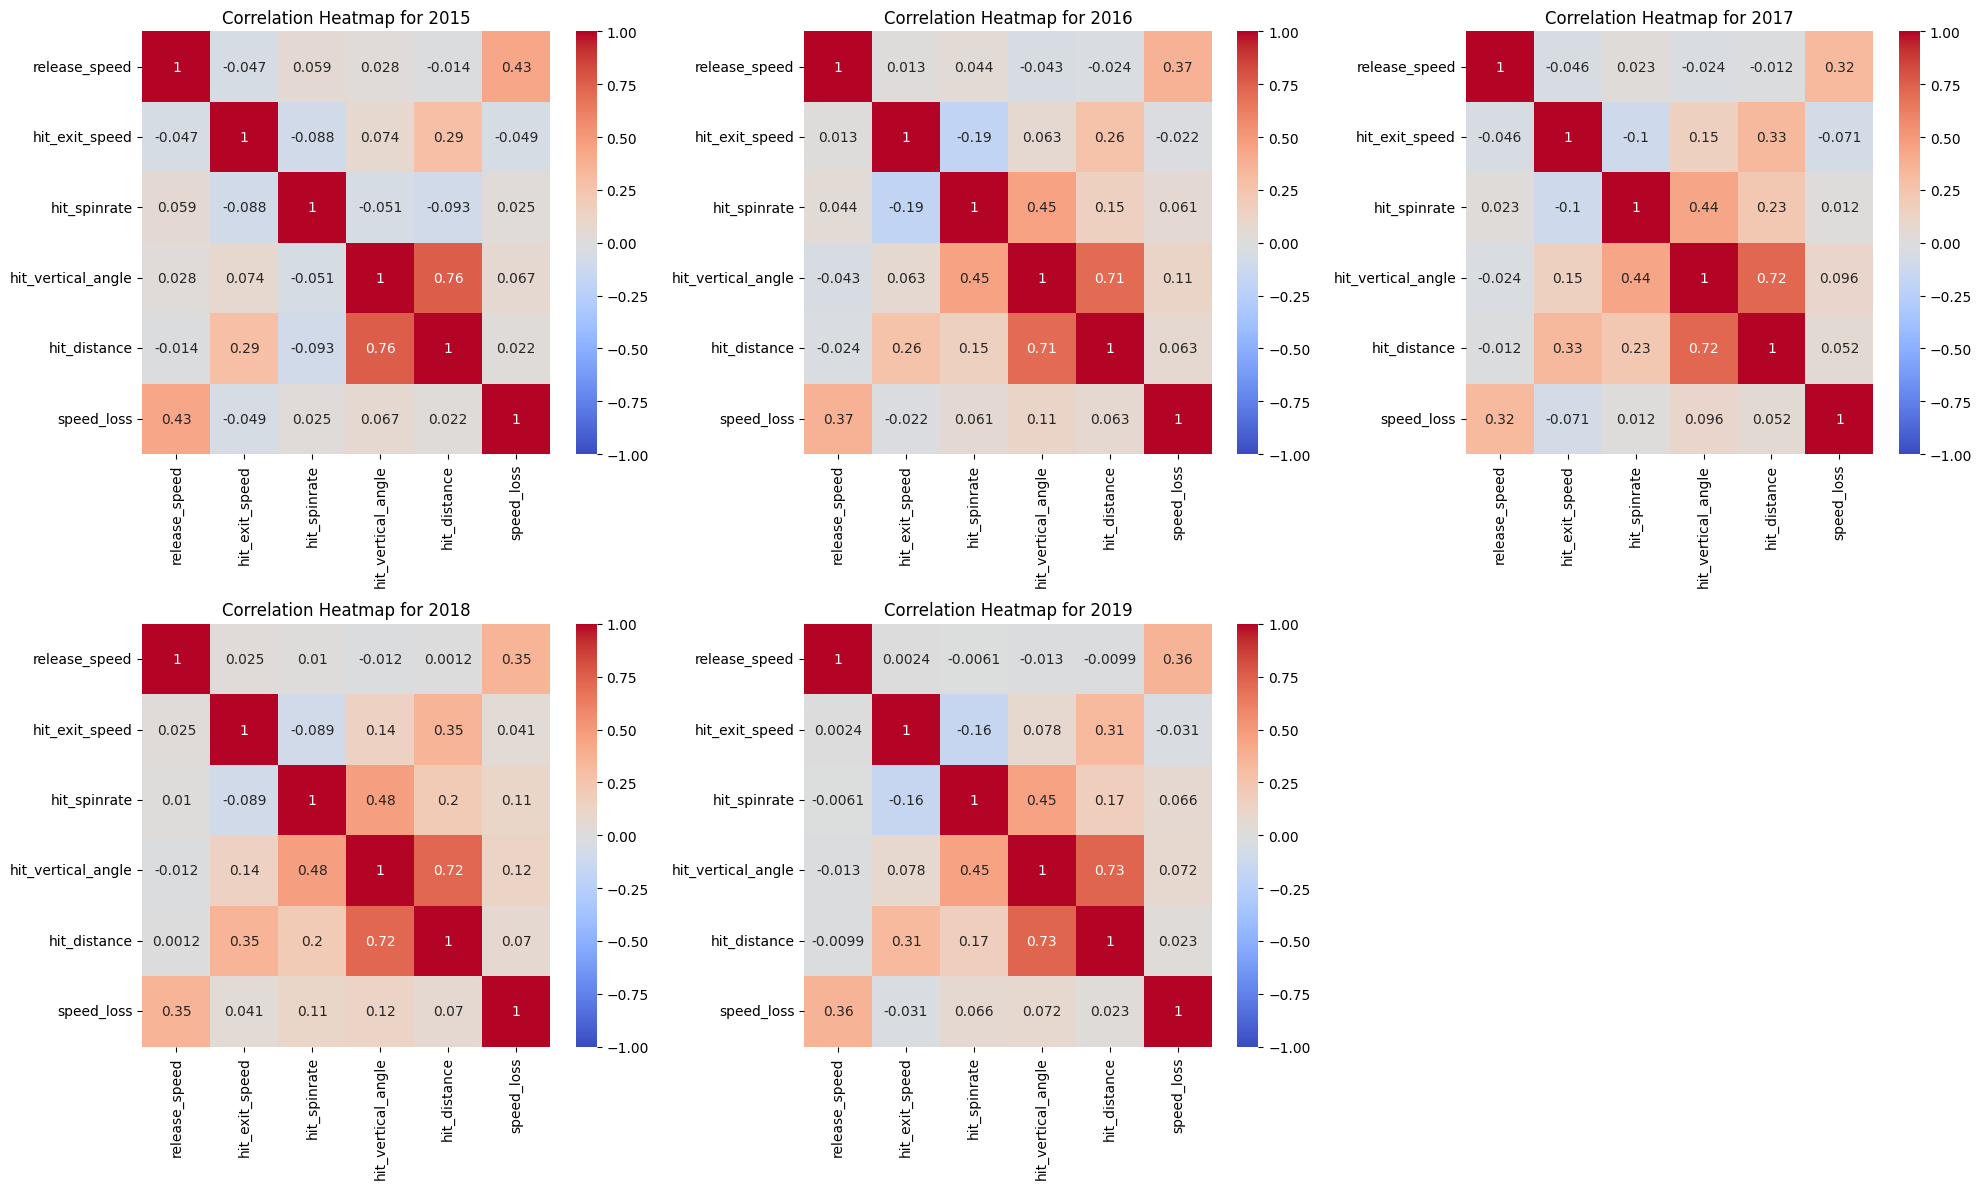

In [73]:
# Function to create correlation heatmaps for multiple years in a 2x3 grid
def plot_correlation_heatmaps(data, years):
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    axes = axes.flatten()

    for i, year in enumerate(years):
        year_data = data[data['year'] == year]
        correlation_matrix = year_data[['release_speed', 'hit_exit_speed', 'hit_spinrate',
                                        'hit_vertical_angle', 'hit_distance', 'speed_loss']].corr()
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, ax=axes[i])
        axes[i].set_title(f'Correlation Heatmap for {year}')

    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

years = cleaned_data['year'].unique()
years.sort()

plot_correlation_heatmaps(cleaned_data, years)
